In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


/usr/local/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home = './data')

In [3]:
#display(mnist)
#display(mnist.data)
#display(mnist.target)
display(mnist.data.shape)
display(mnist.target.shape)

(70000, 784)

(70000,)

In [4]:
data = mnist.data
target = mnist.target

In [5]:
data.shape

(70000, 784)

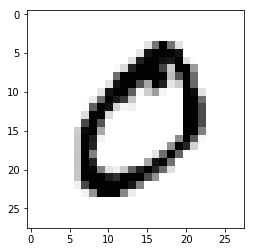

In [6]:
plt.imshow(data[0,:].reshape([28,28]), cmap='Greys')
plt.show()

In [7]:
n_samples, n_pix = data.shape
n_samples


70000

# Augmentation

In [ ]:
from PIL import Image

dataL = np.zeros([n_samples*5,n_pix])
targetL = np.zeros([n_samples*5])
index=0
for i in range(n_samples):
    for j in range(-2,3):
        #im = Image.fromarray(np.uint8(data[0,:].reshape([28,28])))
        dataL[index,:] = np.array( Image.fromarray(data[i,:].reshape([28,28])).rotate(j*5) ).ravel()
        targetL[index]=target[i]
        index +=1
        
#im = Image.fromarray(data[0,:].reshape([28,28]))
#imAr = np.array( im.transform(im.size, Image.AFFINE, (1, 1, 0, 1, 1, 0)) ).ravel()

display(dataL.shape)


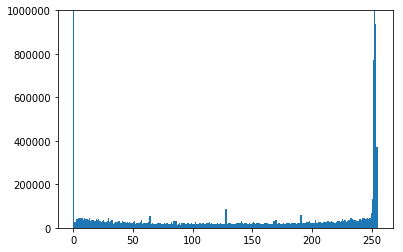

In [8]:
plt.hist(data.ravel(), bins =256)
plt.ylim([0,1e6])
plt.show()

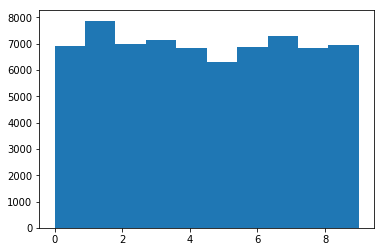

In [9]:
plt.hist(target, bins=10)
plt.show()

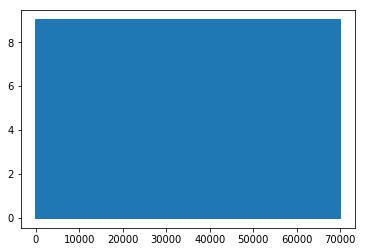

In [10]:
from sklearn.utils import shuffle

data, target = shuffle(data,target, random_state=0)
#dataL, targetL = shuffle(dataL,targetL, random_state=0)


plt.plot(target)
plt.show()

In [11]:

#X_train, X_test, y_train, y_test = train_test_split(dataL, targetL, test_size=0.1, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(data[0:n_samples//10,:], target[0:n_samples//10], test_size=0.1, random_state=42)

X_train.shape

(6300, 784)

# Neighbor

In [12]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train) 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [13]:
neigh.predict(X_test[0:3,:])

array([4., 3., 6.])

In [14]:
neigh.predict_proba(X_test[0:3,:])

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [15]:
neigh.score(X_test,y_test)

0.9442857142857143

# Neural Network

In [16]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(hidden_layer_sizes=(70,30))
classifier.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(70, 30), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [17]:
classifier.predict(X_test[0:3,:])

array([4., 3., 6.])

In [18]:
classifier.score(X_test,y_test)
#got 0.958 right out of the box with MLPclassifier
#got 0.970 with augmentation of plus minus 2*10degree of rotating
#got 0.966 with hidden_layer_sizes=(100,20,)   , no augmentation
#for much smaller dataset / 10   I get 0.91 on default and only 0.75 for hidden_layer_sizes=(100,20,) (not enough data to train right)

0.8614285714285714

# Tensorflow basics
http://adventuresinmachinelearning.com/python-tensorflow-tutorial/

In [19]:
const = tf.constant(2.0, name='const')
#b = tf.Variable(2.0, name='b')
b = tf.placeholder(tf.float32, [None, 1], name='b')
c = tf.Variable(1.0, name='c')
d = tf.add(b,c, name='d')
e = tf.add(c, const, name='e')
a = tf.multiply(d,e, name='a')

init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)
    #a_out=sess.run(a)
    a_out = sess.run(a, feed_dict={b: np.arange(0, 10)[:, np.newaxis]})
    print('Variable a is {}'.format(a_out))
    

Variable a is [[ 3.]
 [ 6.]
 [ 9.]
 [12.]
 [15.]
 [18.]
 [21.]
 [24.]
 [27.]
 [30.]]


# Tensorflow solution with tensorflow data

In [20]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

learning_rate = 0.5
epochs = 2
batch_size = 100

n_L0 = 784
n_L1 = 300

x = tf.placeholder(tf.float32, [None,n_L0])
y = tf.placeholder(tf.float32, [None, 10])

W1 = tf.Variable(tf.random_normal([n_L0, n_L1], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random_normal([n_L1]), name='b1')
W2 = tf.Variable(tf.random_normal([n_L1, 10], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random_normal([10]), name='b2')

L1_x = tf.add(tf.matmul(x, W1), b1)
L1_z = tf.nn.relu(L1_x)

L2_x = tf.add(tf.matmul(L1_z, W2), b2)
y_ = tf.nn.softmax(L2_x)

y_clipped = tf.clip_by_value(y_ , 1e-10, 0.9999999)
cross_entropy = -tf.reduce_mean(tf.reduce_sum(y * tf.log(y_clipped)+ (1 - y) * tf.log(1 - y_clipped), axis=1))
optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

init_op = tf.global_variables_initializer()

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# start the session
with tf.Session() as sess:
   # initialise the variables
   sess.run(init_op)
   total_batch = int(len(mnist.train.labels) / batch_size)
   for epoch in range(epochs):
        avg_cost = 0
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size=batch_size)
            _, c = sess.run([optimiser, cross_entropy], feed_dict={x: batch_x, y: batch_y})
            avg_cost += c / total_batch
        print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost))
   print(sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Epoch: 1 cost = 0.531
Epoch: 2 cost = 0.202
0.9693


# Tensorflow with original data from above

In [21]:
learning_rate = 0.5
epochs = 10
batch_size = 100

n_L0 = 784
n_L1 = 300

x = tf.placeholder(tf.float32, [None, n_L0])
y = tf.placeholder(tf.float32, [None, 10])
#yV = tf.placeholder(tf.float32, [None])
#y = tf.one_hot(tf.cast(yV,tf.int32),10)

W1 = tf.Variable(tf.random_normal([n_L0, n_L1], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random_normal([n_L1]), name='b1')
W2 = tf.Variable(tf.random_normal([n_L1, 10], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random_normal([10]), name='b2')

L1_x = tf.add(tf.matmul(x, W1), b1)
L1_z = tf.nn.relu(L1_x)

L2_x = tf.add(tf.matmul(L1_z, W2), b2)
y_ = tf.nn.softmax(L2_x)

y_clipped = tf.clip_by_value(y_ , 1e-10, 0.9999999)
cross_entropy = -tf.reduce_mean(tf.reduce_sum(y * tf.log(y_clipped)+ (1 - y) * tf.log(1 - y_clipped), axis=1))
optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

init_op = tf.global_variables_initializer()

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [22]:
# start the session
with tf.Session() as sess:
    # initialise the variables
    sess.run(init_op)
    total_batch = int(len(y_train) / batch_size)
    for epoch in range(epochs):
        avg_cost = 0
        for i in range(total_batch):
            batch_x = X_train[i*batch_size:(i+1)*batch_size,:]/256
            #batch_y = tf.one_hot(y_train[i*batch_size:(i+1)*batch_size],10)
            batch_y = y_train[i*batch_size:(i+1)*batch_size]
            batch_y_one_hot = np.zeros([batch_size,10])
            for j in range(len(batch_y)):
                batch_y_one_hot[j,int(batch_y[j])]=1
            _, c = sess.run([optimiser, cross_entropy], feed_dict={x: batch_x, y: batch_y_one_hot})
            avg_cost += c / total_batch
        print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost))
    
    y_test_one_hot = np.zeros([len(y_test),10])
    for j in range(len(y_test)):
        y_test_one_hot[j,int(y_test[j])]=1
    print(sess.run(accuracy, feed_dict={x: X_test, y: y_test_one_hot}))

Epoch: 1 cost = 1.825
Epoch: 2 cost = 0.690
Epoch: 3 cost = 0.421
Epoch: 4 cost = 0.307
Epoch: 5 cost = 0.234
Epoch: 6 cost = 0.180
Epoch: 7 cost = 0.140
Epoch: 8 cost = 0.108
Epoch: 9 cost = 0.085
Epoch: 10 cost = 0.068
0.9242857


# Tensorflow 3 layer 

In [23]:
learning_rate = 0.5
epochs = 10
batch_size = 100

n_L0 = 784
n_L1 = 50
n_L2 = 20
n_L3 = 10

x = tf.placeholder(tf.float32, [None, n_L0])
#y = tf.placeholder(tf.float32, [None, 10])
yV = tf.placeholder(tf.float32, [None])
y = tf.one_hot(tf.cast(yV,tf.int32),10)

W1 = tf.Variable(tf.random_normal([n_L0, n_L1], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random_normal([n_L1]), name='b1')
W2 = tf.Variable(tf.random_normal([n_L1, n_L2], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random_normal([n_L2]), name='b2')
W3 = tf.Variable(tf.random_normal([n_L2, n_L3], stddev=0.03), name='W3')
b3 = tf.Variable(tf.random_normal([n_L3]), name='b3')

L1_x = tf.add(tf.matmul(x, W1), b1)
L1_z = tf.nn.relu(L1_x)

L2_x = tf.add(tf.matmul(L1_z, W2), b2)
L2_z = tf.nn.relu(L2_x)

L3_x = tf.add(tf.matmul(L2_z, W3), b3)
y_ = tf.nn.softmax(L3_x)

y_clipped = tf.clip_by_value(y_ , 1e-10, 0.9999999)
cross_entropy = -tf.reduce_mean(tf.reduce_sum(y * tf.log(y_clipped)+ (1 - y) * tf.log(1 - y_clipped), axis=1))
optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

init_op = tf.global_variables_initializer()

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [24]:
# start the session
with tf.Session() as sess:
    # initialise the variables
    sess.run(init_op)
    total_batch = int(len(y_train) / batch_size)
    for epoch in range(epochs):
        avg_cost = 0
        for i in range(total_batch):
            batch_x = X_train[i*batch_size:(i+1)*batch_size,:]/256
            batch_y = y_train[i*batch_size:(i+1)*batch_size]
            batch_y_one_hot = np.zeros([batch_size,10])
            for j in range(len(batch_y)):
                batch_y_one_hot[j,int(batch_y[j])]=1
            _, c = sess.run([optimiser, cross_entropy], feed_dict={x: batch_x, yV: batch_y})
            avg_cost += c / total_batch
        print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost))
    
    y_test_one_hot = np.zeros([len(y_test),10])
    for j in range(len(y_test)):
        y_test_one_hot[j,int(y_test[j])]=1
    print(sess.run(accuracy, feed_dict={x: X_test, yV: y_test}))
    
#maybe too many parameters and we need to train longer

Epoch: 1 cost = 2.802
Epoch: 2 cost = 1.706
Epoch: 3 cost = 0.978
Epoch: 4 cost = 0.861
Epoch: 5 cost = 0.547
Epoch: 6 cost = 0.420
Epoch: 7 cost = 0.366
Epoch: 8 cost = 0.362
Epoch: 9 cost = 0.266
Epoch: 10 cost = 0.281
0.8857143


# Tensorflow simple 2 layer use layers.dense and built in entropy

In [25]:
learning_rate = 0.5
epochs = 10
batch_size = 100
n_L0 = 784
n_L1 = 300

x = tf.placeholder(tf.float32, [None, n_L0])
y = tf.placeholder(tf.float32, [None, 10])

L1_z = tf.layers.dense(inputs=x,    units=300, activation=tf.nn.relu)
L2_x = tf.layers.dense(inputs=L1_z, units=10)

y_ = tf.nn.softmax(L2_x)

cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=tf.argmax(input=y, axis=1), logits=L2_x)
    
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [26]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    total_batch = int(len(y_train) / batch_size)
    for epoch in range(epochs):
        avg_cost = 0
        for i in range(total_batch):
            batch_x = X_train[i*batch_size:(i+1)*batch_size,:]/256
            batch_y = y_train[i*batch_size:(i+1)*batch_size]
            batch_y_one_hot = np.zeros([batch_size,10])
            for j in range(len(batch_y)):
                batch_y_one_hot[j,int(batch_y[j])]=1
            _, c = sess.run([optimizer, cross_entropy], feed_dict={x: batch_x, y: batch_y_one_hot})
            avg_cost += c / total_batch
        print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost))
    
    y_test_one_hot = np.zeros([len(y_test),10])
    for j in range(len(y_test)):
        y_test_one_hot[j,int(y_test[j])]=1
    print(sess.run(accuracy, feed_dict={x: X_test, y: y_test_one_hot}))

Epoch: 1 cost = 0.714
Epoch: 2 cost = 0.295
Epoch: 3 cost = 0.212
Epoch: 4 cost = 0.160
Epoch: 5 cost = 0.125
Epoch: 6 cost = 0.098
Epoch: 7 cost = 0.078
Epoch: 8 cost = 0.063
Epoch: 9 cost = 0.051
Epoch: 10 cost = 0.041
0.95857143


# Tensorflow convolution nn

In [27]:
learning_rate = 0.5
epochs = 1
batch_size = 100
n_L0 = 784
n_L1 = 300

x = tf.placeholder(tf.float32, [None, n_L0])
y = tf.placeholder(tf.float32, [None, 10])

#L1_z = tf.layers.dense(inputs=x,    units=300, activation=tf.nn.relu)
#L2_x = tf.layers.dense(inputs=L1_z, units=10)

input_layer = tf.reshape(x, [-1, 28, 28, 1])

conv1 = tf.layers.conv2d(inputs=input_layer, filters=32,
      kernel_size=[5, 5],padding="same",activation=tf.nn.relu, name='conv1')
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

conv2 = tf.layers.conv2d(inputs=pool1, filters=64,
      kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64]) # first dim corresponds to batch size
dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

logits = tf.layers.dense(inputs=dense, units=10) #note there is no activation

y_ = tf.nn.softmax(logits)

cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=tf.argmax(input=y, axis=1), logits=logits)
loss = tf.reduce_mean(cross_entropy) # i forgot this line

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [29]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    total_batch = int(len(y_train) / batch_size)
    for epoch in range(epochs):
        avg_cost = 0
        for i in range(total_batch):
            batch_x = X_train[i*batch_size:(i+1)*batch_size,:]/256
            batch_y = y_train[i*batch_size:(i+1)*batch_size]
            batch_y_one_hot = np.zeros([batch_size,10])
            for j in range(len(batch_y)):
                batch_y_one_hot[j,int(batch_y[j])]=1
            _, c = sess.run([optimizer, cross_entropy], feed_dict={x: batch_x, y: batch_y_one_hot})
            avg_cost += c / total_batch
        print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost))
    
    y_test_one_hot = np.zeros([len(y_test),10])
    for j in range(len(y_test)):
        y_test_one_hot[j,int(y_test[j])]=1
    print(sess.run(accuracy, feed_dict={x: X_test, y: y_test_one_hot}))
    
    #names = [op.name for op in graph.get_operations() if op.type=='Conv2D']
    #[var.name for var in tf.trainable_variables()]
    var2 = [v for v in tf.trainable_variables() if v.name == 'conv2d_1/kernel:0']
    v = sess.run(var2)
    #print(var2)
    #print(v)
    
#0.988! 
#0.994 (5 ep) with augmentation but somehow i did not shuffle
#0.977 (1 ep) with augmentation but somehow i never had the loss line
#0.993 with augmentation and 10 epochs and shuffle

Epoch: 1 cost = 2.290
0.27285713


# Tensorflow advanced with estimator

In [30]:
# see file: tf_tutorial_mnist

# Tensorflow with Keras
http://localhost:8888/notebooks/Google%20Drive/AI_Residency/PythonNotebooks/TensorFlow-Tutorials/03C_Keras_API.ipynb

In [31]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)
data.test.cls = np.argmax(data.test.labels, axis=1)

Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [32]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import InputLayer, Input,Reshape, MaxPooling2D, Conv2D, Dense, Flatten

In [33]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
img_shape_full = (img_size, img_size, 1)
num_channels = 1
num_classes = 10

In [34]:
inputs = Input(shape=(img_size_flat,))
net = inputs
net = Reshape(img_shape_full)(net)
net = Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
             activation='relu', name='layer_conv1')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)
net = Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
             activation='relu', name='layer_conv2')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)
net = Flatten()(net)
net = Dense(128, activation='relu')(net)
net = Dense(num_classes, activation='softmax')(net)
outputs = net

In [35]:
model2 = Model(inputs=inputs, outputs=outputs)
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [36]:
model2.fit(x=data.train.images,y=data.train.labels,epochs=1, batch_size=128)

Epoch 1/1
55000/55000 [==============================] - 42s 765us/step - loss: 0.2042 - acc: 0.9367


In [37]:
result = model2.evaluate(x=data.test.images,y=data.test.labels)

10000/10000 [==============================] - 3s 323us/step


In [38]:
for name, value in zip(model2.metrics_names, result):
    print(name, value)
print("{0}: {1:.2%}".format(model2.metrics_names[1], result[1]))

loss 0.051101757599134
acc 0.9832
acc: 98.32%


In [39]:
y_pred = model2.predict(x=data.test.images)
cls_pred = np.argmax(y_pred, axis=1)

In [40]:
path_model = 'model.keras'
model2.save(path_model)

# with tensorboard somehow not working


In [41]:
import numpy as np
import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [42]:
from __future__ import print_function



learning_rate = 0.5
epochs = 5
batch_size = 100

n_L0 = 784
n_L1 = 300

x = tf.placeholder(tf.float32, [None,n_L0])
y = tf.placeholder(tf.float32, [None, 10])

W1 = tf.Variable(tf.random_normal([n_L0, n_L1], stddev=0.03), name='W1')
b1 = tf.Variable(tf.random_normal([n_L1]), name='b1')
W2 = tf.Variable(tf.random_normal([n_L1, 10], stddev=0.03), name='W2')
b2 = tf.Variable(tf.random_normal([10]), name='b2')

L1_x = tf.add(tf.matmul(x, W1), b1)
L1_z = tf.nn.relu(L1_x)

L2_x = tf.add(tf.matmul(L1_z, W2), b2)
y_ = tf.nn.softmax(L2_x)

y_clipped = tf.clip_by_value(y_ , 1e-10, 0.9999999)
cross_entropy = -tf.reduce_mean(tf.reduce_sum(y * tf.log(y_clipped)+ (1 - y) * tf.log(1 - y_clipped), axis=1))
loss = tf.reduce_mean(cross_entropy)
optimiser = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)




init_op = tf.global_variables_initializer()

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

logs_path = '/tmp/tensorflow_logs/MYexample/'
tf.summary.scalar("loss", loss)
tf.summary.scalar("accuracy", tf.reduce_mean(tf.cast(accuracy, tf.float32)))
merged_summary_op = tf.summary.merge_all()

# start the session
with tf.Session() as sess:
    # initialise the variables
    sess.run(init_op)
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    total_batch = int(len(mnist.train.labels) / batch_size)
    for epoch in range(epochs):
        avg_cost = 0
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size=batch_size)
            _, c, summary = sess.run([optimiser, cross_entropy, merged_summary_op], feed_dict={x: batch_x, y: batch_y})
            #_, c = sess.run([optimiser, cross_entropy], feed_dict={x: batch_x, y: batch_y})
            avg_cost += c / total_batch
            summary_writer.add_summary(summary, epoch * total_batch + i)
        print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost))
        
        
    print(sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}))
    
print("Run the command line:\n" \
          "--> tensorboard --logdir=/tmp/tensorflow_logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")


#this shit only works once and then kernel needs to be restarted
    

Epoch: 1 cost = 0.735
Epoch: 2 cost = 0.258
Epoch: 3 cost = 0.191
Epoch: 4 cost = 0.157
Epoch: 5 cost = 0.125
0.969
Run the command line:
--> tensorboard --logdir=/tmp/tensorflow_logs 
Then open http://0.0.0.0:6006/ into your web browser


# more tensorboard

In [43]:
'''
Graph and Loss visualization using Tensorboard.
This example is using the MNIST database of handwritten digits
(http://yann.lecun.com/exdb/mnist/)

Author: Aymeric Damien
Project: https://github.com/aymericdamien/TensorFlow-Examples/
'''

from __future__ import print_function

import tensorflow as tf

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Parameters
learning_rate = 0.01
training_epochs = 2
batch_size = 100
display_step = 1
logs_path = '/tmp/tensorflow_logs/MYexampleAdv/'

# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph Input
# mnist data image of shape 28*28=784
x = tf.placeholder(tf.float32, [None, 784], name='InputData')
# 0-9 digits recognition => 10 classes
y = tf.placeholder(tf.float32, [None, 10], name='LabelData')


# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Create a summary to visualize the first layer ReLU activation
    tf.summary.histogram("relu1", layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Create another summary to visualize the second layer ReLU activation
    tf.summary.histogram("relu2", layer_2)
    # Output layer
    out_layer = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
    return out_layer

# Store layers weight & bias
weights = {
    'w1': tf.Variable(tf.random_normal([n_input, n_hidden_1]), name='W1'),
    'w2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2]), name='W2'),
    'w3': tf.Variable(tf.random_normal([n_hidden_2, n_classes]), name='W3')
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1]), name='b1'),
    'b2': tf.Variable(tf.random_normal([n_hidden_2]), name='b2'),
    'b3': tf.Variable(tf.random_normal([n_classes]), name='b3')
}

# Encapsulating all ops into scopes, making Tensorboard's Graph
# Visualization more convenient
with tf.name_scope('Model'):
    # Build model
    pred = multilayer_perceptron(x, weights, biases)

with tf.name_scope('Loss'):
    # Softmax Cross entropy (cost function)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))

with tf.name_scope('SGD'):
    # Gradient Descent
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    # Op to calculate every variable gradient
    grads = tf.gradients(loss, tf.trainable_variables())
    grads = list(zip(grads, tf.trainable_variables()))
    # Op to update all variables according to their gradient
    apply_grads = optimizer.apply_gradients(grads_and_vars=grads)

with tf.name_scope('Accuracy'):
    # Accuracy
    acc = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    acc = tf.reduce_mean(tf.cast(acc, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("accuracy", acc)
# Create summaries to visualize weights
for var in tf.trainable_variables():
    tf.summary.histogram(var.name, var)
# Summarize all gradients
for grad, var in grads:
    tf.summary.histogram(var.name + '/gradient', grad)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path,
                                            graph=tf.get_default_graph())

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop), cost op (to get loss value)
            # and summary nodes
            _, c, summary = sess.run([apply_grads, loss, merged_summary_op],
                                     feed_dict={x: batch_xs, y: batch_ys})
            # Write logs at every iteration
            summary_writer.add_summary(summary, epoch * total_batch + i)
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

    print("Optimization Finished!")

    # Test model
    # Calculate accuracy
    print("Accuracy:", acc.eval({x: mnist.test.images, y: mnist.test.labels}))

    print("Run the command line:\n" \
          "--> tensorboard --logdir=/tmp/tensorflow_logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")


Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

INFO:tensorflow:Summary name c:0 is illegal; using c_0 instead.
INFO:tensorflow:Summary name W1:0 is illegal; using W1_0 instead.
INFO:tensorflow:Summary name b1:0 is illegal; using b1_0 instead.
INFO:tensorflow:Summary name W2:0 is illegal; using W2_0 instead.
INFO:tensorflow:Summary name b2:0 is illegal; using b2_0 instead.
INFO:tensorflow:Summary name W1_1

ValueError: Tried to convert 'values' to a tensor and failed. Error: None values not supported.

# train save restore

In [44]:
from __future__ import print_function

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

import tensorflow as tf

# Parameters
learning_rate = 0.001
batch_size = 100
display_step = 1
model_path = "/tmp/model.ckpt"

# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)

# tf Graph input
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])


# Create model
def multilayer_perceptron(x, weights, biases):
    # Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    # Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    # Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

# Store layers weight & bias
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

# Construct model
pred = multilayer_perceptron(x, weights, biases)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# 'Saver' op to save and restore all the variables
saver = tf.train.Saver()

# Running first session
print("Starting 1st session...")
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Training cycle
    for epoch in range(3):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", \
                "{:.9f}".format(avg_cost))
    print("First Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels}))

    # Save model weights to disk
    save_path = saver.save(sess, model_path)
    print("Model saved in file: %s" % save_path)

# Running a new session
print("Starting 2nd session...")
with tf.Session() as sess:
    # Initialize variables
    sess.run(init)

    # Restore model weights from previously saved model
    saver.restore(sess, model_path)
    print("Model restored from file: %s" % save_path)

    # Resume training
    for epoch in range(7):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_x,
                                                          y: batch_y})
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch + 1), "cost=", \
                "{:.9f}".format(avg_cost))
    print("Second Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Accuracy:", accuracy.eval(
        {x: mnist.test.images, y: mnist.test.labels}))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Starting 1st session...
Epoch: 0001 cost= 173.773194369
Epoch: 0002 cost= 42.036626941
Epoch: 0003 cost= 26.631709171
First Optimization Finished!
Accuracy: 0.9044
Model saved in file: /tmp/model.ckpt
Starting 2nd session...
INFO:tensorflow:Restoring parameters from /tmp/model.ckpt
Model restored from file: /tmp/model.ckpt
Epoch: 0001 cost= 18.522173668
Epoch: 0002 cost= 13.519820244
Epoch: 0003 cost= 9.965822144
Epoch: 0004 cost= 7.444633588
Epoch: 0005 cost= 5.424372345
Epoch: 0006 cost= 4.066486219
Epoch: 0007 cost= 2.983093687
Second Optimization Finished!
Accuracy: 0.9355


# Submission

In [ ]:
my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': predicted_prices})
# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)



In [ ]:
predictions = model.predict_classes(X_test, verbose=0)

submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": predictions})
submissions.to_csv("DR.csv", index=False, header=True)

In [ ]:
[var.name for var in tf.trainable_variables()]